# Imports

In [ ]:
# Set to True if Debugging
_DEBUG = False
SEED = 1234

# Imports
import unittest
import networkx as nx

# Utilities

In [ ]:
import matplotlib.pyplot as plt
import math

def plot(G, pos=None, seed=20532, label_options=None):
    if pos == None:
        pos = nx.spring_layout(G, seed=seed)
    if label_options == None:
        label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    if len(G) < 100:
        fs = 14
    else:
        fs = 10
    nx.draw(G, pos)
    nx.draw_networkx_labels(G, pos, font_size=fs, bbox=label_options)
    plt.show()

def makestr(u, v):
    return f"{u}_{v}"

def LogSpace(lower, upper, epsilon):
    ts = []
    if epsilon > 0.0:
        ilower = math.ceil(math.log(lower)/math.log(1+epsilon))
        val = (1+epsilon) ** ilower
        while val <= upper:
            ts.append(val)
            ilower += 1
            val = (1+epsilon) ** ilower
    else:
        raise RunTimeError("LogSpace: epsilon must be a positive real-number (is: ", epsilon, ").")
    return ts


In [ ]:
LogSpace(1, 100, 0.3)

[1.0,
 1.3,
 1.6900000000000002,
 2.197,
 2.8561000000000005,
 3.7129300000000005,
 4.826809000000001,
 6.274851700000002,
 8.157307210000003,
 10.604499373000003,
 13.785849184900005,
 17.921603940370005,
 23.29808512248101,
 30.287510659225312,
 39.37376385699291,
 51.18589301409078,
 66.54166091831802,
 86.50415919381344]

In [ ]:
import os
import gzip
import shutil
import requests

# Download graph
def download_graph_files(name_list):
    if os.path.exists(f"datasets/{name_list[0]}.txt"):
        return

    name_to_filelink = {
            "pokec" : "http://snap.stanford.edu/data/soc-pokec-relationships.txt.gz",
            "enron" : "http://snap.stanford.edu/data/email-Enron.txt.gz",
            "twitter": "http://snap.stanford.edu/data/twitter_combined.txt.gz"
        } 

    # Download graph
    for name in name_list:
        url = name_to_filelink[name]
        filename = url.split("/")[-1]
        with open(filename, "wb") as f:
            r = requests.get(url)
            f.write(r.content)
        
    # Unzip
    os.makedirs("datasets") if not os.path.exists("datasets") else None
    with gzip.open(filename, 'rb') as f_in:
        with open('datasets/'+name+'.txt', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

# run download
download_graph_files(["enron"])       # download_graph_files(["enron", "pokec"]) for both graphs

# Graph-Networkx

In [ ]:
import numpy as np

class Graph_Networkx():
    '''
    Loads a directed graph into memory in networkx format and returns Graph_Networkx object. 
    A directed edge from u to v represents that u influences v.
    !TODO: Store graphs in files. 
    '''
    name_to_graph = {}
    def __init__(self, name):   # DBLP part excluded
        self._name = name
        
        # File links are in txt format.
        names = set(["pokec", "enron", "synBA", "twitter"])

        if not self._name in names:
            raise Exception("Unknown graph name. Input to Graph() should be in {}".format(
                list(names)
            )) 

        filepath = 'datasets/{}.txt'.format(self._name)  # filepath => filename
        print("Reading graph from", filepath, "...")
        self._graph = nx.read_edgelist(filepath, create_using=nx.DiGraph, nodetype=int)
        self._neighbours = {n: list(nbrdict) for n, nbrdict in self._graph.adjacency()}
        self._leftVertices = list(set([i for i, j in self._graph.edges]))
        self._rightVertices = list(set([j for i, j in self._graph.edges]))
        print("Read", nx.info(self._graph))

    def __copy__(self):
        raise Exception("Graph cannot be copied")
    
    def __deepcopy__(self):
        raise Exception("Graph cannot be copied")

    @staticmethod
    def get_graph(name):
        if not name in Graph_Networkx.name_to_graph:
            Graph_Networkx.name_to_graph[name] = Graph_Networkx(name)
        return Graph_Networkx.name_to_graph[name]

    def get_edges(self):
        return self._graph.edges
    
    def get_size(self):
        return self._graph.size()

    def get_coverable_vertices(self):
        return self._rightVertices

    def get_universe_vertices(self):
        return self._leftVertices

    def get_neighbours(self, i):
        return self._neighbours[i]

    def get_graph_name(self):
        return self._name
    

## Tests

In [ ]:
 import random

 class TestGraph(unittest.TestCase):
    graph_name = "enron"
    filepath = 'datasets/{}.txt'.format(graph_name)  # filepath => filename
    G = nx.read_edgelist(filepath, create_using=nx.DiGraph, nodetype=int)
    graph = Graph_Networkx.get_graph(graph_name)

    def test_enron(self):
        '''Test case function to check correct loading of dataset'''
        result = TestGraph.graph._graph.number_of_nodes(), TestGraph.graph._graph.number_of_edges()
        expected = (36692, 367662)
        self.assertEqual(result, expected)
    
    # def test_pokec(self):
    #     '''Test case function to check correct loading of dataset'''
    #     TestGraph.graph = Graph.get_graph("pokec")
    #     result = TestGraph.graph._numVertices, TestGraph.graph._numEdges
    #     expected = (1632803, 30622564)
    #     self.assertEqual(result, expected)

    def test_neighbour_count(self):
        '''Test case function to check if all neighbour counts are correct'''
       # test
        node = TestGraph.graph.get_universe_vertices()[int(random.random()*len(TestGraph.graph.get_universe_vertices()))]
        self.assertEqual(len(list(TestGraph.G.successors(node))), len(TestGraph.graph.get_neighbours(node)))
    
    def test_neighbour_vertices(self):
        '''Test case function to check if all neighbour vertices are correct'''
        # test
        node = TestGraph.graph.get_universe_vertices()[int(random.random()*len(TestGraph.graph.get_universe_vertices()))]
        self.assertEqual(list(TestGraph.G.successors(node)), TestGraph.graph.get_neighbours(node))
    
    def test_empty_neighbours(self):
        '''Test case function to check if a node without neighbours returns empty list'''
        try:
            node = (set(TestGraph.graph.get_coverable_vertices()) - set(TestGraph.graph.get_universe_vertices())).pop()
        except KeyError as e:
            print("All elements have neighbours.")
            print(e)
            return
        print(node)
        assert(node not in TestGraph.graph.get_universe_vertices())
        self.assertEqual(TestGraph.graph.get_neighbours(node), [])

Reading graph from datasets/enron.txt ...
Read DiGraph with 36692 nodes and 367662 edges


In [ ]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_empty_neighbours (__main__.TestGraph)
Test case function to check if a node without neighbours returns empty list ... ok
test_enron (__main__.TestGraph)
Test case function to check correct loading of dataset ... ok
test_neighbour_count (__main__.TestGraph)
Test case function to check if all neighbour counts are correct ... ok
test_neighbour_vertices (__main__.TestGraph)
Test case function to check if all neighbour vertices are correct ... 

All elements have neighbours.
'pop from an empty set'


ok

----------------------------------------------------------------------
Ran 4 tests in 0.048s

OK


# Create Synthetic Graphs

In [ ]:
import networkx as nx
class Barabasi_Albert_Graph(object):
    def __init__(self, N, m):
        '''
        N: Number of nodes in the graph
        m: Number of nodes preferentially attached to every new node.
        '''
        self.N = N
        self.m = m
        self._graph = None
    
    def create(self, seed=None):
        self._graph = nx.scale_free_graph(self.N, seed=seed)
        self._name = "synBA"
        print(nx.info(self._graph))
    
    def store_edge_list(self):
        if self._graph == None:
            raise Exception("Graph not yet created. First call obj.create() and then obj.store_edge_list().")
        uniq_edges = list({f"{u} {v}\n" for (u, v, _) in list(self._graph.edges)})
        with open(f"datasets/{self._name}.txt", "w") as f:
            f.writelines(uniq_edges)
    
    def plot(self):
        plot(self._graph)


ba = Barabasi_Albert_Graph(1000, 3) # Change to (5000, 3) and run all to replicate the experiments
ba.create(seed=SEED) 
ba.store_edge_list()

MultiDiGraph with 1000 nodes and 2198 edges


# Submodular Function

In [ ]:
from abc import abstractmethod
import numpy as np
from copy import copy

class SubmodularFunction():
    _oracle_calls = 0   # Why static i.e. common to all objects? continuous variable like time. We consider ddifference for calcs.

    @abstractmethod
    def reset(self):
        '''
        Sets S = empty set.
        '''
        pass

    @abstractmethod
    def add(self, element):
        '''
        Adds a new element to set S.
        '''
        pass

    @abstractmethod
    def delta(self, element):
        '''
        Computes f(S u {e}) - f(S).
        '''
        pass

    @abstractmethod
    def get_universe(self):
        '''
        Returns the universe of the utility function. (refer Graph)
        '''
        pass

    @abstractmethod
    def get_universe_size(self):
        '''
        Returns the size of the universe of the utility function. (refer Graph)
        '''
        pass

    @abstractmethod
    def get_name(self):
        '''
        Get name of utility function.    
        '''
        pass

    @abstractmethod
    def clone(self):
        '''
        Clone the object
        '''
        pass

    def add_and_increase_oracle_call(self, element, thres=None):
        '''
        Adds element 'e' to the function using Add(e) and also increases
        oracle_calls.
        '''
        SubmodularFunction._oracle_calls += 1   # considering oracle calls are counted irrespective of the contribution because oracle_calls is a sort of time measure
        if thres == None:                           # two parameter format
            # SubmodularFunction._oracle_calls += 1
            return self.add(element)
        else:                                       # three parameter format
        #   Adds element if and only if its contribution is >= thres.
        #   Return the contribution increase.
            delta_e = self.delta(element)
            if delta_e >= thres:
                self.add(element)
                # self._f_val += delta_e
                return delta_e
            else:
                return 0.

    def delta_and_increase_oracle_call(self, element):
        '''
        Returns the delta by adding this element using Delta(e) and also increases
        oracle_calls.
        '''
        SubmodularFunction._oracle_calls += 1
        return self.delta(element)
    
    def get_opt_estimates(self, cardinality_k, epsilon_for_opt_estimates):
        '''
        Returns the guess of the optimum solution. (Refer SieveStreaming paper: http://ww.cs.cornell.edu/~ashwin85/docs/frp0328-badanidiyuru.pdf)
        '''
        '''
        Gets geometrically increasing sequence of estimates for OPT.
        Should be always run on an empty function.
        Used for Sieve-Streaming and for our algorithm.
        Could optimize: this gets re-estimated every time an algorithm is run.
        '''
        # EPSILON_FOR_OPT_ESTIMATES = 0.3

        '''
        Elements with delta less than this wont be considered. For the experiments,
        mostly the delta values are integer so values smaller way than 1 are
        simply double errors.
        '''
        MIN_CONSIDERED_DELTA = 1e-11
        lb_opt = 1.0
        ub_opt = lb_opt * cardinality_k
        # print("k", cardinality_k, "lbopt, ubopt", (lb_opt, ub_opt))
        return LogSpace(lb_opt, ub_opt, epsilon_for_opt_estimates)    # Refer https://www.geeksforgeeks.org/numpy-logspace-python/


## Graph Utility

In [ ]:
class GraphUtility(SubmodularFunction):
    def __init__(self, graph_name):
        # self._graph = Graph.get_graph(graph_name) # construct graph
        self._graph = Graph_Networkx.get_graph(graph_name) # construct graph
        self._present_elements = {n:False for n in self._graph.get_coverable_vertices()}
        # self._f_val = 0.0
        self.univ_size = len(self._graph.get_universe_vertices())   # Added

    # Removes all the data that it has
    def reset(self):
        self._present_elements = {n:False for n in self._graph.get_coverable_vertices()}
    
    # The delta added by inserting this element.
    def delta(self, element):
        val = 0
        for x in self._graph.get_neighbours(element):
            if not self._present_elements[x]:
                val += 1
        return val
    
    # Adds element e.
    def add(self, element):
        for x in self._graph.get_neighbours(element):
            self._present_elements[x] = True

    def get_universe(self):
        return self._graph.get_universe_vertices()
    
    def get_universe_size(self):
        return self.univ_size
    
    def get_edges(self):
        return list(self._graph.get_edges())
    
    def get_num_edges(self):
        return self._graph.get_size()
    
    def get_name(self):
        # return "Graph(" + self._graph.get_graph_name() + ")"
        return "Graph_Networkx(" + self._graph.get_graph_name() + ")"

    def clone(self):
        return GraphUtility(self._graph._name) # returns an exclusive pointer to self.Only that pointer points to the object.

### Tests

In [ ]:
import numpy as np
test_sub = GraphUtility('synBA')
ks = np.arange(10, 201, 10)
for k in ks:
    estimates = test_sub.get_opt_estimates(k, 0.3)
    print(k, estimates[-1], len(estimates))

Reading graph from datasets/synBA.txt ...
Read DiGraph with 1000 nodes and 1781 edges
10 8.157307210000003 9
20 17.921603940370005 12
30 23.29808512248101 13
40 39.37376385699291 15
50 39.37376385699291 15
60 51.18589301409078 16
70 66.54166091831802 17
80 66.54166091831802 17
90 86.50415919381344 18
100 86.50415919381344 18
110 86.50415919381344 18
120 112.45540695195746 19
130 112.45540695195746 19
140 112.45540695195746 19
150 146.1920290375447 20
160 146.1920290375447 20
170 146.1920290375447 20
180 146.1920290375447 20
190 146.1920290375447 20
200 190.04963774880812 21


## Custom Submodular Function

In [ ]:
# class GraphUtilityforIC(SubmodularFunction):
#     # stores actions instead of elements
#     def __init__(self, graph_name):
#         self._graph = Graph_Networkx.get_graph(graph_name) # construct graph
#         self._present_actions = {makestr(u,v):False for u, v in self._graph.get_edges()}
#         self._present_elements = {n:False for n in self._graph.get_coverable_vertices()}
#         # self._f_val = 0.0
#         self.univ_size = len(self._graph.get_num_edges())   # Added

#     # Removes all the data that it has
#     def reset(self):
#         self._present_actions = {makestr(u, v):False for u, v in self._graph.get_edges()}
#         self._present_elements = {n:False for n in self._graph.get_coverable_vertices()}
    
#     # The delta added by inserting this action.
#     def delta(self, action):
#         val = 0
#         u, v = action
#         for x in self._graph.get_neighbours(u):
#             if not self._present_elements[x]:
#                 val += 1
#         return val
    
#     # Adds element e.
#     def add(self, element):
#         pass

#     def get_universe(self):
#         pass
    
#     @abstractmethod
#     def get_universe_size(self):
#         pass
    
#     def get_name(self):
#         pass

#     def clone(self):
#         return CustomSubmodularFunction() # returns an exclusive pointer to self.Only that pointer points to the object.

# Algorithms

In [ ]:
from abc import ABC, abstractmethod

class Algorithm(ABC):
    '''
    Abstract class for algorithms. Must implement all methods in this class in your derived class
    '''
    def __init__(self, sub_func_f, cardinality_k): 
        """
        Must be implemented in the derived algorithm class.
        """ 
        self._sub_func_f = sub_func_f.clone()    # Is .copy() required?
        self._cardinality_k = cardinality_k
    
    @abstractmethod
    def insert(self, element): 
        """
        Must be implemented in the derived algorithm class.
        """ 
        pass

    @abstractmethod
    def erase(self, element): 
        """
        Must be implemented in the derived algorithm class.
        """ 
        pass

    @abstractmethod
    def get_solution_value(self): 
        """
        Must be implemented in the derived algorithm class.
        """ 
        pass

    @abstractmethod
    def get_solution_vector(self): 
        """
        Must be implemented in the derived algorithm class.
        """ 
        pass

    @abstractmethod
    def get_algorithm_name(self): 
        """
        Must be implemented in the derived algorithm class.
        """ 
        pass

## Random Subset Algorithm

In [ ]:
class RandomSubsetAlgorithm(Algorithm):
    def __init__(self, sub_func_f, cardinality_k):
        super(RandomSubsetAlgorithm, self).__init__(sub_func_f, cardinality_k)
        self._universe_elements = []
        self._universe_elements_size = 0
        self._solution = []
        self._solution_size = 0
    
    def insert(self, element):
        if self._solution_size < self._cardinality_k:
            self.append_and_increment(True, element)
        else:
            self.append_and_increment(False, element)
            prob_in_random_solution = self._cardinality_k / (self._cardinality_k + self._universe_elements_size)
            random_value = random.random()
            if random_value < prob_in_random_solution:
                rand_idx = random.randint(0, self._solution_size-1)
                self._solution[rand_idx], self._universe_elements[-1] =  self._universe_elements[-1], self._solution[rand_idx]
    
    def erase(self, element):
        if self.remove_and_decrement(True, element):
            if not self._universe_elements_size == 0:
                rand_ele = self._universe_elements.pop(random.randint(0, self._universe_elements_size-1))
                self._universe_elements_size -= 1
                self.append_and_increment(True, rand_ele)
            return
        self.remove_and_decrement(False, element)
    
    def get_solution_value(self):
        self._sub_func_f.reset()
        obj_val = 0.
        for element_in_solution in self._solution:
            obj_val += self._sub_func_f.add_and_increase_oracle_call(element_in_solution, -1)
        SubmodularFunction._oracle_calls -=  self._solution_size;    # logic behind this statement?
        # Should be just one call in our model.
        return obj_val
    
    def get_solution_vector(self):
        return self._solution

    def get_algorithm_name():
        return "Totally Random Algorithm"

    def append_and_increment(self, is_solution, element):
        if not is_solution:
            self._universe_elements.append(element)
            self._universe_elements_size += 1
        elif is_solution :
            self._solution.append(element)
            self._solution_size += 1    

    def remove_and_decrement(self, is_solution, element):
        if not is_solution:
            try:
                self._universe_elements.remove(element)
                self._universe_elements_size -= 1    
            except ValueError:
                return False
            return True
        elif is_solution:
            try:
                self._solution.remove(element)
                self._solution_size -= 1
            except ValueError:
                return False
            return True

## Greedy Algorithm

In [ ]:
class GreedyAlgorithm(Algorithm):
    def __init__(self, sub_func_f, cardinality_k):
        super(GreedyAlgorithm, self).__init__(sub_func_f, cardinality_k)
        self._available_elements = set()
    
    def insert(self, element):
        self._available_elements.add(element)
    
    def erase(self, element):
        if element not in self._available_elements:
            return
        self._available_elements.remove(element)
    
    def get_solution_value(self):
        self._sub_func_f.reset()
        obj_val = 0.
        for i in range(self._cardinality_k):
            best = (-1, -1)
            for x in self._available_elements:
                best = max(best, (self._sub_func_f.delta_and_increase_oracle_call(x), x))
            if best[0] < 1e-11:
                break
            else:
                self._sub_func_f.add_and_increase_oracle_call(best[1])
                obj_val += best[0]
        return obj_val
    
    def get_solution_vector(self):
        self._sub_func_f.reset()
        solution = []
        for i in range(self._cardinality_k):
            best = (-1, -1)
            for x in self._available_elements:
                best = max(best, (self._sub_func_f.delta_and_increase_oracle_call(x), x))
            if best[0] < 1e-11:
                break
            else:
                self._sub_func_f.add_and_increase_oracle_call(best[1])
                solution.append(best[1])
        return solution

    def get_algorithm_name():
        return "Greedy (simple)"


## Sieve Streaming

In [ ]:
DELETED_ELEMENT = -1    # constant for soft deletions in streams
class SieveStreaming(Algorithm):
    def __init__(self, sub_func_f, cardinality_k):
        self._sieves = []
        epsilon_for_opt_estimates = 0.3
        for gamma in sub_func_f.get_opt_estimates(cardinality_k, epsilon_for_opt_estimates):
            self._sieves.append(
                self.SingleThresholdSieve(sub_func_f, cardinality_k, gamma)
                )
        self._stream = []
        self._stream_size = 0
        self._position_on_stream = {}
    
    def get_solution_value(self):
        best = 0.0
        for sieve in self._sieves:
            best = max(best, sieve.get_solution_value())
        return best
    
    def get_solution_vector(self):
        best = 0.0
        for sieve in self._sieves:
            tmp = sieve.get_solution_value()
            solution = sieve.get_solution_vector()
            if tmp > best:
                best = tmp
                solution = sieve.get_solution_vector()
        return solution

    def insert(self, element):
        # if element in self._position_on_stream:
        #     raise Exception("Element is being inserted again despite not being deleted.")
        self._position_on_stream[element] = self._stream_size   # latest element on stream
        self._stream.append(element)
        self._stream_size += 1  # storing all elements from the input in stream format
        for sieve in self._sieves:
            sieve.process(element)
    
    def erase(self, element):
        if not element in self._position_on_stream:
            raise Exception("element is being deleted but was never inserted.")
        pos = self._position_on_stream.pop(element)
        self._stream[pos] = DELETED_ELEMENT # soft-delete

        for sieve in self._sieves:  # time complexity of deletion ranges over all elements in the stream. Mentioned by Mitrovic et. al in their paper
            if sieve.is_in_solution(element):
                sieve.reset()
                for el in self._stream:
                    if not el == DELETED_ELEMENT:
                        sieve.process(el)

    def get_algorithm_name(): return "Sieve Streaming"

    class SingleThresholdSieve():
        def __init__(self, sub_func_f, cardinality_k, gamma):
            self._sub_func_f = sub_func_f.clone()
            self._cardinality_k = cardinality_k
            self._gamma = gamma
            self._obj_vals = [0.0]
            self._solution = [] # a class List_with_size could be implemented.
            self._solution_size = 0
        
        #  Process the arrival of a new element e on the stream.
        def process(self, element):
            if self._solution_size < self._cardinality_k:
                delta_e = self._sub_func_f.add_and_increase_oracle_call(element, (self._gamma / 2.0 - self._obj_vals[-1]) / (self._cardinality_k - self._solution_size))
                # A constant that is used to controll the value of the elements added.
                # Values less than this are basically zero (to avoid double errors).
                EPSILON_TO_ADD = 1e-11
                if delta_e > EPSILON_TO_ADD:
                    self._solution.append(element)
                    self._solution_size += 1
                    self._obj_vals.append(self._obj_vals[-1] + delta_e)
                else:
                    pass    # Do nothing; solution already full
            
        def reset(self):
            self._sub_func_f.reset()
            self._solution.clear()
            self._solution_size = 0
            self._obj_vals = [0.0]
        
        def is_in_solution(self, element):
            try:
                self._solution.index(element)
            except ValueError:
                return False
            return True
        
        def get_solution_value(self):
            return self._obj_vals[-1]
        
        def get_solution_vector(self):
            return self._solution



## Influential Checkpoints

In [ ]:
from collections import deque

# IC Maintenance
class IC_Maintenance(Algorithm):
    def __init__(self, sub_func_f, cardinality_k, window_size): 
        super(IC_Maintenance, self).__init__(sub_func_f, cardinality_k)
        self._window_size = window_size
        self._checkpoints = deque([])
        for i in range(window_size):
            self._checkpoints.append(SieveStreaming(sub_func_f, cardinality_k))
        print("IC Init complete")
    
    def insert(self, element): 
        self._checkpoints.popleft()
        self._checkpoints.append(SieveStreaming(self._sub_func_f, self._cardinality_k))
        # for i in range(self._window_size-1):
        #     self._checkpoints[i] = self._checkpoints[i+1]
        for i in range(self._window_size):
            self._checkpoints[i].insert(element)

    def erase(self, element): 
        """
        Must be implemented in the derived algorithm class.
        """ 
        pass

    def get_solution_value(self): 
        return self._checkpoints[0].get_solution_value()

    def get_solution_vector(self): 
        return self._checkpoints[0].get_solution_vector()

    def get_algorithm_name(): 
        return "IC Maintenance"

## Alg-Simple

In [ ]:
from collections import deque

'''
Fully Dynamic Algorithm
'''
# Alg-Simple
DELETED_ELEMENT = -1    # constant for soft deletions in streams
class AlgSimple(Algorithm):
    def __init__(self, sub_func_f, cardinality_k):
        pass

    def get_solution_value(self):
        pass
    
    def get_solution_vector(self):
        pass
    def insert(self, element):
        pass

    def erase(self, element):
        pass
    def get_algorithm_name(): return "Alg Simple"

    class SimpleThreshold():
        def __init__(self, num_T, sub_func_f, cardinality_k, gamma, eps):
            pass
        
        # // Process the arrival of a new element e on the stream.
        def process(self, element):
            pass
            
        def reset(self):
            pass
        
        def is_in_solution(self, element):
            pass
        
        def get_solution_value(self):
            return self._obj_vals[-1]
        
        def get_solution_vector(self):
            return self._solution

        def level_construct(self, l_begin):
            '''
             For levels lower than l_begin, just condition f on the S-sets of those
            levels.

            When we are at l, this is the size of S_1 u S_2 u ... S_l.
            '''
            self._size_of_S = 0
            self._sub_func_f.reset()
            for l in range(l_begin):
                for e in self._solution_S[l]:
                    self._sub_func_f.add_and_increase_oracle_call(e)
                    self._sub_func_f._oracle_calls -= 1
                    self._size_of_S += 1
        



# Experiments

## Window Experiment

In [ ]:
from tqdm import tqdm

def window_experiment_general(sub_func_f, algo, window_size, **kwargs):
    values = []
    window_size = min(window_size, sub_func_f.get_universe_size())
    # print("Universe")
    # print(sub_func_f.get_universe())
    for i in tqdm(range(sub_func_f.get_universe_size() + window_size)):
        # There are more elements to insert
        if i < sub_func_f.get_universe_size():
            algo.insert(sub_func_f.get_universe()[i])
        
        if i >= window_size:
            algo.erase(sub_func_f.get_universe()[i - window_size])
        values.append(algo.get_solution_value())

    sum_values = 0.; len_values = 0
    for v in values:
        sum_values += v; len_values += 1
    return sum_values/len_values
        



In [ ]:
'''
Window experiment for IC Maintenance algorithm.
'''
from tqdm import tqdm

def window_experiment_for_IC(sub_func_f, algo, window_size, **kwargs):
    values = []
    window_size = min(window_size, sub_func_f.get_num_edges())
    for i in tqdm(range(sub_func_f.get_num_edges() + window_size)):
        # There are more elements to insert
        if i < sub_func_f.get_num_edges():
            algo.insert(sub_func_f.get_edges()[i][0])
        
        if i >= window_size:
            algo.erase(sub_func_f.get_edges()[i - window_size][0])
        values.append(algo.get_solution_value())

    sum_values = 0.; len_values = 0
    for v in values:
        sum_values += v; len_values += 1
    return sum_values/len_values
        



## Run Experiment for Algorithm

In [ ]:

import pandas as pd
import random
def run_experiment_for_algorithms(experiment, sub_func_f, Algos, cardinality_ks, *args, seed=None, **kwargs):
    if not seed == None:
        random.seed(seed)
    print(f"Submodular Function: {sub_func_f.get_name()}")
    results = []
    for Algo in Algos:
        print(f"Now running {Algo.get_algorithm_name()}")
        values_per_k, oracle_calls_per_k = [], []
        for cardinality_k in cardinality_ks:
            print(f"Running k = {cardinality_k}")
            if Algo.get_algorithm_name() in ["Greedy (simple)", "Totally Random Algorithm", "Sieve Streaming"]:
                algo = Algo(sub_func_f, cardinality_k)
            else:
                algo = Algo(sub_func_f, cardinality_k, **kwargs)
            
            oracle_calls_at_start = SubmodularFunction._oracle_calls

            value = experiment(sub_func_f, algo, **kwargs)
            values_per_k.append(value)
            oracle_calls_per_k.append(SubmodularFunction._oracle_calls - oracle_calls_at_start)
            
        # Print results for current algorithm
        res = pd.DataFrame({"k": cardinality_ks, "f": values_per_k, "Oracle Calls": oracle_calls_per_k})
        results.append(res)
    return results


## Main

In [ ]:
if __name__ == "__main__":
    Algos = [RandomSubsetAlgorithm, SieveStreaming]
    # Algos = [IC_Maintenance]  # Also change experiment variable
    # sub_func_f
    # Choose a graph from ["synBA", "enron", "twitter", "pokec"] ... increasing order of sizes 
    f_syn = GraphUtility("synBA")   # Change graph parameters in "Create Synthetic Graphs" section.
    # Potential values of cardinality constraint that can be used
    from10to200 = np.arange(10, 201, 10)
    # Potential values of cardinality constraint that can be used
    from20to100 = np.arange(20, 101, 20)
    experiment = window_experiment_general  # Use window_experiment_for_IC if running IC_Maintenance
    
    print("Sliding Window Experiment")
    cardinality_ks = from20to100
    for window_size in [10000]:
        print(f"Window size {window_size}")
        results = run_experiment_for_algorithms(
            experiment,
            f_syn,
            Algos,
            cardinality_ks,
            window_size=window_size
        )

        for i, Algo in enumerate(Algos):
            res = results[i]
            res.plot('k', ['f', 'Oracle Calls'], xticks=cardinality_ks, title=f'{Algo.get_algorithm_name()}', subplots=True)



Sliding Window Experiment
Window size 10000
Submodular Function: Graph_Networkx(synBA)
Now running Totally Random Algorithm
Running k = 20


100%|██████████| 1770/1770 [00:00<00:00, 15173.86it/s]


Running k = 40


100%|██████████| 1770/1770 [00:00<00:00, 8053.01it/s]


Running k = 60


100%|██████████| 1770/1770 [00:00<00:00, 6883.33it/s]


Running k = 80


100%|██████████| 1770/1770 [00:00<00:00, 5078.68it/s]


Running k = 100


100%|██████████| 1770/1770 [00:00<00:00, 4323.95it/s]


Now running Sieve Streaming
Running k = 20


100%|██████████| 1770/1770 [00:04<00:00, 365.69it/s]


Running k = 40


100%|██████████| 1770/1770 [00:10<00:00, 174.94it/s]


Running k = 60


100%|██████████| 1770/1770 [00:16<00:00, 109.93it/s]


Running k = 80


100%|██████████| 1770/1770 [00:23<00:00, 74.71it/s]


Running k = 100


 81%|████████  | 1437/1770 [00:26<00:08, 37.99it/s]

# Results

#### Greedy on SynBA graph
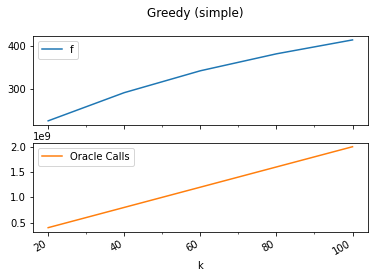!

#### Sieve Streaming on SynBA graph:
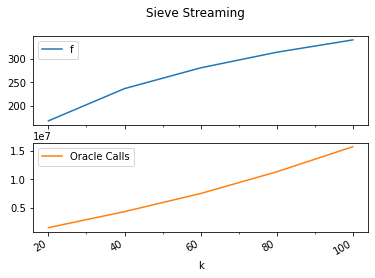!
#### Random on SynBA graph
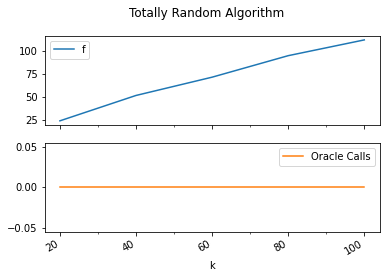

#### Random on Enron graph:
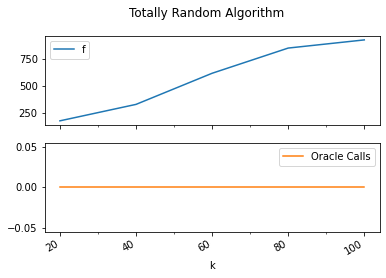

#### Sieve Streaming on Enron graph:
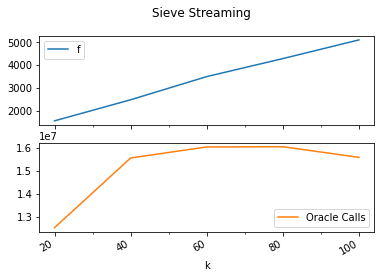

#### Influential Checkpoint Maintenance on SynBA graph:
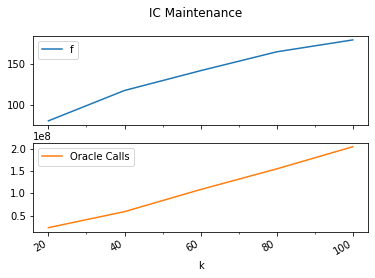

# References
1. https://github.com/google-research/google-research/tree/master/fully_dynamic_submodular_maximization
2. https://arxiv.org/pdf/1702.01586.pdf
3. https://github.com/sbuschjaeger/SubmodularStreamingMaximization